In [1]:
import datetime
import json
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import requests
import seaborn as sns

In [2]:
d1 = requests.get("https://theunitedstates.io/congress-legislators/legislators-historical.json").json()
d2 = requests.get("https://theunitedstates.io/congress-legislators/legislators-current.json").json()
data = d1 + d2
len(data)

12677

In [3]:
def make_dataframe(year):
    results = []
    for politician in data:
        name  = " ".join([politician["name"]["first"], politician["name"]["last"]])
        dob   = politician["bio"].get("birthday")
        sex   = "Male" if politician["bio"]["gender"] == "M" else "Female"
        terms = politician["terms"]
        for term in terms:
            start = int(term["start"].split('-')[0])
            end   = int(term["end"].split('-')[0])
            state = term["state"]
            party = term.get("party")
            type_ = "Senate" if term["type"] == 'sen' else "House"
            if start < year <= end:
                results.append(dict(
                    name=name,
                    dob=dob,
                    sex=sex,
                    party=party,
                    state=state,
                    type=type_
                ))
    dataframe = pd.DataFrame(results)
    dataframe.dropna(inplace=True)
    
    dataframe['age'] = (pd
                        .to_datetime(dataframe['dob'])
                        .apply(lambda x: (datetime.datetime(year,1,1) - x).days / 365))
    cut_bins = [20, 35, 50, 65, 80, 95, 110]
    cut_labels = ["20-34", "35-49", "50-64", "65-79", "80-94", "95+"]
    dataframe['age_bin'] = pd.cut(dataframe['age'], bins=cut_bins, labels=cut_labels)
    
    return dataframe     

In [4]:
def pop_pyramid(dataframe, year, column, col1, col2, ratio='split'):
    
    pvt = (dataframe
           .pivot_table(
            index='age_bin', 
            columns=column, 
            aggfunc='count', 
            values='name', 
            fill_value=0))
    
    medians = dataframe.groupby(column)['age'].median().apply(lambda x: round(x,1))
    
    bgcolor = 'White'
    txtcolor = 'Black'
    leftcolor = "#D3B36D"
    rightcolor = "#72B0A9"
    xtick_range = [0,10,20,30,40,50]

    fig = plt.figure(figsize=(6,5.5), dpi=144, facecolor=bgcolor, edgecolor=bgcolor)
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])

    y = pvt.index
    
    if ratio == 'split':
        lenx1 = len(dataframe[dataframe[column] == col1])
        lenx2 = len(dataframe[dataframe[column] == col2])
    else:
        lenx1 = len(dataframe)
        lenx2 = len(dataframe)

    x1 = pvt[col1] / lenx1 * 100
    ax1.barh(y, x1, align='center', color=leftcolor, height=.95)    
    ax1.set_xticks(xtick_range)
    ax1.set_xlim(0,50)    
    ax1.set_yticklabels([])    
    ax1.tick_params(axis='both', which='major', labelsize=10, colors=bgcolor)
    ax1.tick_params(axis='x', length=4, colors=txtcolor)
    ax1.tick_params(axis='y', length=0, colors=txtcolor)
    ax1.set_facecolor(bgcolor)
    ax1.set_xlabel(col1, color=txtcolor, fontsize=10)
    ax1.invert_xaxis()
        
    x2 = pvt[col2] / lenx2 * 100
    ax2.barh(y, x2, align='center', color=rightcolor, height=.95) 
    ax2.set_xticks(xtick_range)
    ax2.set_xlim(0,50)
    ax2.tick_params(axis='x', which='major', labelsize=10, colors=bgcolor)
    ax2.tick_params(axis='x', length=4, colors=txtcolor)
    ax2.tick_params(axis='y', length=0)
    ax2.set_facecolor(bgcolor)        
    ax2.set_xlabel(col2, color=txtcolor, fontsize=10)

    ax1.text(25, 5.25, medians[col1], color=leftcolor, fontsize=16, ha='center')
    ax1.text(25, 5, "median age", color=leftcolor, fontsize=10, ha='center')
    ax2.text(25, 5.25, medians[col2], color=rightcolor, fontsize=16, ha='center')
    ax2.text(25, 5, "median age", color=rightcolor, fontsize=10, ha='center')

    for spine in ax1.spines.values():
        spine.set_edgecolor(bgcolor)
    for spine in ax2.spines.values():
        spine.set_edgecolor(bgcolor)  
    ax1.spines['bottom'].set_edgecolor(txtcolor)
    ax1.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_edgecolor(txtcolor)
    ax2.spines['left'].set_visible(False)
    
    fig.subplots_adjust(wspace=0.24, hspace=0)
    fig.suptitle(f"Population Pyramid of US Government", fontsize=14, ha='center')
    ax1.set_title(f"{year}   ", fontsize=28, ha='center')
    
    return fig

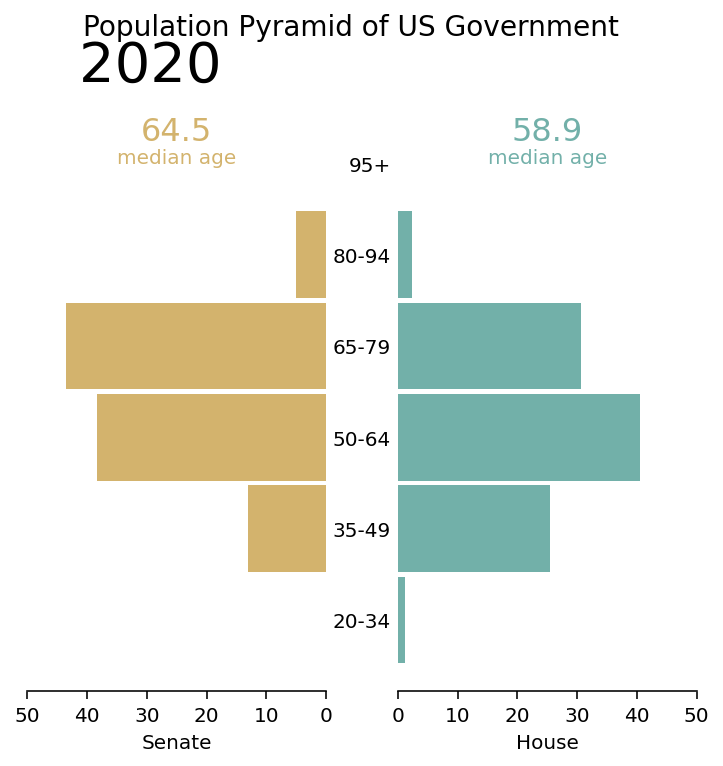

In [5]:
year = 2020
df = make_dataframe(year)
f = pop_pyramid(df, year, 'type', 'Senate', 'House')

In [8]:
senate_ages = []
house_ages = []
year_range = [y for y in range(1980,2024)]

def make_charts(year):
    
    col1 = "Senate"
    col2 = "House"
    
    df = make_dataframe(year)
    
    senate_ages.append(df.query("type == @col1")["age"].median())
    house_ages.append(df.query("type == @col2")["age"].median())
    
    fig = pop_pyramid(df, year, 'type', col1, col2, ratio='split')
    path = f"legislators-age/{year}.png"
    fig.savefig(path, format='png', pad_inches=2,
        facecolor='white', edgecolor='auto')
    
for year in year_range:
    make_charts(year)    

Text(2022, 59.80684931506849, 'House')

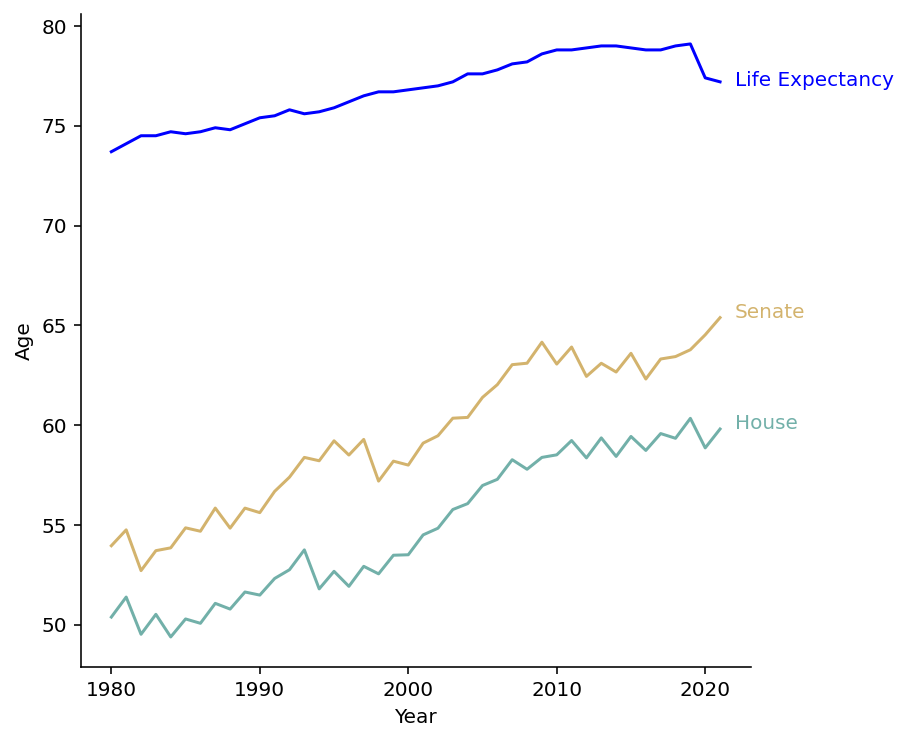

In [7]:
fig, ax = plt.subplots(figsize=(6,6), dpi=144, facecolor='white', edgecolor='white')

age_range = year_range[:-2]

le = pd.read_csv("life-expectancy.csv")
le = le[le['Code'] == "USA"]
le = le.set_index("Year", drop=True).iloc[:,-1:].loc[age_range]
le.columns = ['LE']
le = list(le['LE'])

sns.lineplot(y=senate_ages[:-2], x=age_range, color="#D3B36D")
sns.lineplot(y=house_ages[:-2], x=age_range, color="#72B0A9")
sns.lineplot(y=le, x=age_range, color="blue")

ax.set_xlabel("Year")
ax.set_ylabel("Age")

sns.despine()

ax.text(2022, 77, "Life Expectancy", color="blue")
ax.text(2022, senate_ages[-3], "Senate", color="#D3B36D")
ax.text(2022, house_ages[-3], "House", color="#72B0A9")